# Function Defined in process.py, crawl.py, graph.py
Follow the flow in flow.txt

In [2]:
from datasets import load_dataset

d:\Miniconda3\envs\rag\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [201]:
import re
import unicodedata
from bs4 import BeautifulSoup, Tag, Comment
import json
import os
import numpy as np
import requests
from hdbscan import HDBSCAN
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import List, Tuple
import networkx as nx
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity

## Process HTML

In [65]:
class BlockNode:
    def __init__(self, tag, attributes=None, content=None):
        self.tag = tag
        self.path = []
        self.attributes = attributes or {}
        self.content = content.strip() if content else ""
        self.children = []
        self.block = ""
        self.is_leaf = False
        self.embedding = None

        # Clustering metadata
        self.cluster_label = None  # e.g., -1 for outliers
        self.cluster_prob = None   # Optional: HDBSCAN probability
        self.cluster_strength = None  # Optional: e.g., stability or outlier_score

    def add_child(self, child):
        self.children.append(child)

    def to_dict(self):
        return {
            "tag": self.tag,
            "attributes": self.attributes,
            "content": self.content,
            "children": [child.to_dict() for child in self.children],
            "cluster_label": self.cluster_label,
            "cluster_prob": self.cluster_prob,
            "cluster_strength": self.cluster_strength,
        }

    def __str__(self):
        return (
            f"Tag: {self.tag}, Content: {self.content}, "
            f"Children: {len(self.children)}, Cluster: {self.cluster_label}"
        )

    def __repr__(self):
        return (
            f"<BlockNode tag={self.tag} "
            f"block={self.block!r} "
            f"length={len(self.block.split())} {len(self.content.split())} "
            f"path={self.path} "
            f"children={len(self.children)} "
            f"cluster={self.cluster_label}>"
        )


In [ ]:
def clean_html(html_content: str) -> BeautifulSoup:
    soup = BeautifulSoup(html_content, "html.parser")

    # Remove <script>, <style>, and comments
    for tag in soup(["script", "style"]):
        tag.decompose()
    for comment in soup.find_all(string=lambda t: isinstance(t, Comment)):
        comment.extract()

    # Clean attributes (remove inline styles, overly long values)
    for tag in soup.find_all(True):
        for attr in list(tag.attrs.keys()):
            if attr == "style" or len(str(tag[attr])) > 50:
                del tag[attr]

    # Merge single-nested identical tags
    def merge_single_nested_tags(tag):
        while (
            len(tag.contents) == 1
            and isinstance(tag.contents[0], Tag)
            and tag.contents[0].name == tag.name
        ):
            child = tag.contents[0]
            for k, v in child.attrs.items():
                if k not in tag.attrs:
                    tag.attrs[k] = v
            child.unwrap()
        for child in tag.find_all(recursive=False):
            merge_single_nested_tags(child)

    for tag in soup.find_all(True):
        merge_single_nested_tags(tag)

    # Normalize and clean text content
    def normalize_text(text: str) -> str:
        text = text.replace("\xa0", " ")
        text = re.sub(r"xa0\d*", " ", text)
        text = re.sub(r"\s+", " ", text)
        return unicodedata.normalize("NFKC", text).strip()

    for text_node in soup.find_all(string=True):
        if isinstance(text_node, str):
            cleaned = normalize_text(text_node)
            if cleaned:
                text_node.replace_with(cleaned)
            else:
                text_node.extract()

    # Remove empty tags
    def remove_empty_tags(tag):
        for child in tag.find_all(recursive=False):
            remove_empty_tags(child)
        if not tag.contents or all(
            str(c).strip() in ["", "None"] for c in tag.contents
        ):
            tag.decompose()

    remove_empty_tags(soup)

    return soup


def build_dom_tree(html_content: BeautifulSoup) -> BlockNode:
    def build_tree(element):
        if not getattr(element, "name", None):
            return None

        # FIX: Collect only direct text children (same as original)
        direct_text = []
        for child in element.children:
            if isinstance(child, str):
                text = child.strip()
                if text:
                    direct_text.append(text)

        # ✨ Construct node first
        node = BlockNode(
            tag=element.name, attributes=element.attrs, content=" ".join(direct_text)
        )
        # Recursively build child nodes
        for child in element.children:
            child_node = build_tree(child)
            if child_node:
                node.add_child(child_node)

        if not node.content.strip() and not node.children:
            return None
        
        return node

    def losen_structure(node):
        if not node:
            return
        for child in node.children:
            losen_structure(child)
        i = 0
        while i < len(node.children):
            child = node.children[i]
            if not child.content.strip() and len(child.children) == 1:
                node.children[i] = child.children[0]
            else:
                i += 1

    root = build_tree(html_content)
    losen_structure(root)
    return root

def build_block_tree(dom_tree: BlockNode, max_window_tokens: int) -> List[BlockNode]:
    final_blocks: List[BlockNode] = []

    def safe_token_count(text: str) -> int:
        # return int(len((text or "").split()) * 0.7)
        return max(0, (len((text or "").split()) - 20) // 1.25)

    def split_text_blocks(text: str, max_tokens: int) -> List[List[BlockNode]]:
        """Split a list of BlockNodes into groups, each with <= max_tokens."""
        words = text.split()
        result = []
        current_group = []

        for word in words:
            current_group.append(word)
            if len(current_group) >= max_tokens:
                result.append(" ".join(current_group))
                current_group = []

        if current_group:
            result.append(" ".join(current_group))

        return result

    def process(node: BlockNode):
        ### traverse bottom
        # merge leaf nodes 
        # merge siblings nodes
        # if siblings merged nodes are enough save it to the final blocks
        # if not enough split it then store to the final blocks
        # cut children, travers up.
        if not node:
            return
        
        for child in node.children:
            process(child)

        leaf_children = node.children[:]
        for child in node.children:
            if not child.children:
                continue
            else:
                print("ERROR BUGs OCCUR")
                print(node.content, node.block)
                print(child.content, child.block)

        if not leaf_children:
            return

        for leaf in leaf_children:
            if not leaf.block:
                leaf.block = leaf.content or ""
        if node.block.strip() or node.content.strip():
            print(node.block, node.content, end=" ")
        merged_text = " ".join(child.block for child in leaf_children)

        total_tokens = safe_token_count(merged_text)

        if total_tokens > max_window_tokens:
            # Content too large — must split and finalize here
            for idx, chunk in enumerate(split_text_blocks(merged_text, max_window_tokens)):
                split_node = BlockNode(
                    tag=f"{node.tag}_split_{idx}",
                    content="",  # no content carried
                )
                split_node.block = chunk
                split_node.children = []
                split_node.is_leaf = True
                split_node._is_merged_leaf = True
                split_node.path = node.path[:]
                final_blocks.append(split_node)

            # Do not promote this node — its children were split and finalized
            node.children = []
            node.block = None
            return

        # Otherwise, merged block is still valid
        node.block = (node.content or "") + merged_text
        node.children = []  # critical: consumed children
        node.is_leaf = True
        node._is_merged_leaf = True
        

    def merge_upward(node: BlockNode) -> bool:
        if not node:
            return True

        node.block = node.content or ""

        # Leaf node
        if not node.children:
            node.is_leaf = True
            node._is_merged_leaf = True
            final_blocks.append(node)
            return True

        # Recursively evaluate all children
        for child in node.children:
            merge_upward(child)

        # Check if all children are merged-leaves or raw leaves
        all_leaf = all(
            getattr(child, "_is_merged_leaf", False) or not child.children
            for child in node.children
        )

        # Collapse linear branch
        if not all_leaf and len(node.children) == 1:
            child = node.children[0]
            node.block = f"{node.content or ''} {child.block or child.content or ''}".strip()
            node.children = child.children
            return False

        # Try merging if all children are merged-leaves
        if all_leaf:
            merged_texts = []
            for child in node.children:
                if child.block:
                    merged_texts.append(child.block.strip())

            total_tokens = safe_token_count(node.content) + sum(
                safe_token_count(txt) for txt in merged_texts
            )

            if total_tokens <= max_window_tokens:
                node.block = (node.content or "").strip()
                if merged_texts:
                    if node.block:
                        node.block += " " + " ".join(merged_texts)
                    else:
                        node.block = " ".join(merged_texts)
                node.children = []
                node.is_leaf = True
                node._is_merged_leaf = True
                final_blocks.append(node)
                return True

        # Cannot merge
        node.block = node.block or node.content or ""
        node.is_leaf = False
        node._is_merged_leaf = False
        return False


    def retag_tree(node: BlockNode, tag_counts=None):
        tag_counts = tag_counts or {}
        tag_prefix = "".join(filter(str.isalpha, node.tag)) or "node"
        tag_counts[tag_prefix] = tag_counts.get(tag_prefix, 0) + 1
        node.tag = f"{tag_prefix}{tag_counts[tag_prefix]}"
        node.path = node.path + [node.tag]
        for child in node.children:
            child.path = node.path.copy()
            retag_tree(child, tag_counts)

    if dom_tree.tag == "[document]":
        dom_tree.tag = "document"

    retag_tree(dom_tree)
    # merge_upward(dom_tree)
    process(dom_tree)
    return final_blocks

def fetch_embedding(text_or_texts: str | list[str]) -> list[dict] | None:
    # EMB_MODEL_ID = "text-embedding-mxbai-embed-large-v1"
    EMB_MODEL_ID = "text-embedding-qwen3-embedding-0.6b"
    """Fetch embedding for a given text from LMStudio."""
    try:
        url = "http://localhost:9999/v1/embeddings"
        data = {"model": EMB_MODEL_ID, "input": text_or_texts}
        headers = {"Content-Type": "application/json"}
        response = requests.post(url, headers=headers, data=json.dumps(data))
        # print(response)
        if response.status_code == 200:
            # print(response.json())
            return response.json()["data"]
        else:
            print(f"[Embedding API Error {response.status_code}] {response.text}")
            return None
    except requests.exceptions.RequestException as e:
        print(f"Error querying LMStudio for Embedding: {e}")
        return None


def extract_block_texts(blocks: List[BlockNode]) -> List[str]:
    """Extract non-empty block content from a flat list of final BlockNodes."""
    return [b.block.strip() for b in blocks if b.block and b.block.strip()]

def embed_block_contents(blocks: list[BlockNode], block_contents: list[str]) -> None:
    """Embed a list of block texts and assign to the corresponding BlockNodes."""
    batch_size = 100
    all_embeddings = []

    for i in range(0, len(block_contents), batch_size):
        contents_batch = block_contents[i : i + batch_size]
        batch_embeddings = fetch_embedding(contents_batch)
        if batch_embeddings is None:
            raise RuntimeError(f"Embedding failed for batch {i}-{i + batch_size}")
        all_embeddings.extend(batch_embeddings)

    expected = len([c for c in block_contents if c.strip()])
    if len(all_embeddings) != expected:
        raise ValueError(f"Expected {expected} embeddings, got {len(all_embeddings)}")

    emb_idx = 0
    for block in blocks:
        if block.block and block.block.strip():
            block.embedding = all_embeddings[emb_idx]["embedding"]
            emb_idx += 1

def embed_block_nodes(blocks: list[BlockNode]) -> None:
    """Embed block content of each BlockNode directly, assuming pre-cleaned and tokenized."""
    batch_size = 100
    all_embeddings = []

    valid_blocks = [blk for blk in blocks if blk.block and blk.block.strip()]
    valid_contents = [blk.block for blk in valid_blocks]

    for i in range(0, len(valid_contents), batch_size):
        contents_batch = valid_contents[i : i + batch_size]
        batch_embeddings = fetch_embedding(contents_batch)
        if batch_embeddings is None:
            raise RuntimeError(f"Embedding failed for batch {i}-{i + batch_size}")
        all_embeddings.extend(batch_embeddings)

    if len(all_embeddings) != len(valid_blocks):
        raise ValueError(f"Expected {len(valid_blocks)} embeddings, got {len(all_embeddings)}")

    for blk, emb in zip(valid_blocks, all_embeddings):
        blk.embedding = emb["embedding"]
def collect_leaf_blocks(node: BlockNode) -> list[BlockNode]:
    """Recursively collect all leaf BlockNodes that contain embeddings."""
    if node.is_leaf and node.embedding is not None:
        return [node]
    blocks = []
    for child in node.children:
        blocks.extend(collect_leaf_blocks(child))
    return blocks


def cluster_block_embeddings(blocks: List[BlockNode], min_cluster_size: int = 2) -> None:
    """
    Cluster leaf blocks of the BlockNode tree using HDBSCAN.

    Adds cluster metadata to each leaf node:
    - node.cluster_label: int, -1 for noise
    - node.cluster_prob: float, confidence of assignment
    - node.cluster_strength: float, outlier score (lower is more stable)
    """
    embedded_blocks = [b for b in blocks if b.embedding is not None]
    if not embedded_blocks:
        print("[Clustering skipped] No embedded blocks.")
        return

    embeddings = np.array([b.embedding for b in embedded_blocks])
    if len(embeddings) < min_cluster_size:
        print(
            f"[Clustering skipped] Not enough points to cluster (found {len(embeddings)})."
        )
        return
    print(min_cluster_size)
    clusterer = HDBSCAN(min_cluster_size=min_cluster_size, prediction_data=True)
    labels = clusterer.fit_predict(embeddings)
    probs = clusterer.probabilities_
    strengths = clusterer.outlier_scores_

    for b, label, prob, strength in zip(embedded_blocks, labels, probs, strengths):
        b.cluster_label = int(label)
        b.cluster_prob = float(prob)
        b.cluster_strength = float(strength)

    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"[Clustering complete] {num_clusters} clusters formed")
    


def prune_blocks_by_cluster(
    blocks: List[BlockNode], max_link: int, min_threshold: int = 2
) -> List[BlockNode]:
    """
    Prune blocks based on clustering of embeddings.
    """
    pass


def cluster_and_prune_blocks(
    blocks: List[BlockNode], max_link: int, min_threshold: int = 2, min_cluster_size: int = 2
) -> BlockNode:
    ...
    cluster_block_embeddings(blocks, min_cluster_size)
    pruned_blocks = prune_blocks_by_cluster(blocks, max_link, min_threshold)
    return pruned_blocks

In [230]:
def link_cluster_nodes_topk(G: nx.DiGraph, blocks: List[BlockNode], topk_ratio=0.5):
    clusters = defaultdict(list)
    uid_to_block = {}

    # Step 1: Group blocks by cluster ID
    for block in blocks:
        if hasattr(block, "cluster_label"):
            uid = "_".join(block.path) + "_" + block.tag
            clusters[block.cluster_label].append(uid)
            uid_to_block[uid] = block

    for cluster_id, node_ids in clusters.items():
        if len(node_ids) < 2:
            print("skip trivial clusters")
            continue  # Skip trivial clusters

        embeddings = [G.nodes[uid]["embd"] for uid in node_ids]
        sim_matrix = cosine_similarity(embeddings)

        k = max(1, int(topk_ratio * len(node_ids)))  # Ensure k >= 2

        topk_neighbors = {}
        for i, uid_i in enumerate(node_ids):
            sims = sim_matrix[i]
            top_indices = sims.argsort()[-(k + 1):][::-1]  # top-k excluding self
            topk_neighbors[uid_i] = set(
                node_ids[j] for j in top_indices if node_ids[j] != uid_i
            )
        print(topk_neighbors)
        # Add mutual top-k edges
        for i, uid_i in enumerate(node_ids):
            for j, uid_j in enumerate(node_ids):
                if i >= j:
                    continue
                print(topk_neighbors[uid_i], topk_neighbors[uid_j])
                if uid_j in topk_neighbors[uid_i] and uid_i in topk_neighbors[uid_j]:
                    sim_score = sim_matrix[i][j]
                    G.add_edge(uid_i, uid_j, weight=sim_score)
                    G.add_edge(uid_j, uid_i, weight=sim_score)


        # Fallback for isolated nodes
        for i, uid_i in enumerate(node_ids):
            if G.degree(uid_i) == 0:
                sims = sim_matrix[i]
                sims[i] = -1  # ignore self
                best_idx = np.argmax(sims)
                uid_j = node_ids[best_idx]
                sim_score = sims[best_idx]
                G.add_edge(uid_i, uid_j, weight=sim_score)
                G.add_edge(uid_j, uid_i, weight=sim_score)

def graph_construct(blocks: List[BlockNode], topk_ratio=0.5):
    G = nx.DiGraph()

    # Step 1: Add nodes to the graph
    for block in blocks:
        uid = "_".join(block.path) + "_" + block.tag 
        print(uid)
        G.add_node(uid, tag=block.path[-1], content=block.content, path=block.path, embd=block.embedding)

    # Step 2: Link nodes within each cluster
    link_cluster_nodes_topk(G, blocks, topk_ratio=topk_ratio)
    nx.draw(G)
    return G

## Visualize Functions

In [187]:
def get_leaf_nodes(node) -> list:
    """Recursively collect all leaf nodes with embeddings."""
    if not node.children and node.embedding is not None:
        return [node]
    leaves = []
    for child in node.children:
        leaves.extend(get_leaf_nodes(child))
    return leaves


def visualize_block_clusters(
    block_list: List[BlockNode], method="umap", title="Block Cluster Visualization"
):
    if not block_list or len(block_list) < 4:
        print("Too few blocks to visualize. Need at least 4.")
        return

    embeddings = np.array([node.embedding for node in block_list])
    labels = np.array([getattr(node, "cluster_label", -1) for node in block_list])

    # Step 2: Dimensionality reduction
    if method == "umap":
        n_samples = len(embeddings)
        n_neighbors = min(40, max(2, n_samples - 2))  # at least 2, at most n-2
        reducer = UMAP(
            n_neighbors=n_neighbors,
            n_components=2,  # default
            min_dist=0.1,
            metric="cosine",
            random_state=42
        )
    else:
        raise ValueError("Unsupported method. Use 'umap' or 'tsne'.")

    try:
        reduced = reducer.fit_transform(embeddings)
    except TypeError as e:
        print("UMAP failed due to small sample size or eigen decomposition error:", e)
        return

    # Step 3: Visualization
    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        x=reduced[:, 0],
        y=reduced[:, 1],
        hue=labels,
        palette="tab10",
        s=70,
        legend="full",
    )
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


def traverse_tree(node: BlockNode, level=0):
    """Recursively traverse the tree and print node information."""
    if not node:
        return
    indent = "  " * level
    print(
        f"{indent}Tag: {node.tag}, Content Length: {len(node.content)}, Block: {len(node.block.split(" "))}, "
        f"Children: {len(node.children)}, Cluster: {node.cluster_label}"
    )
    for child in node.children:
        traverse_tree(child, level + 1)

## Execute

In [6]:
ds = load_dataset(
    "google-research-datasets/natural_questions", "dev", split="validation"
)

In [226]:
data = ds[0]["document"]
html_doc = data["html"]

In [225]:
html_doc = sample2 = """<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>More Complex Example</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            line-height: 1.6;
            margin: 20px;
        }
        .container {
            max-width: 800px;
            margin: 0 auto;
            padding: 20px;
            border: 1px solid #ccc;
        }
        h1, h2 {
            color: #333;
        }
        p {
            margin-bottom: 15px;
        }
        ul {
            list-style-type: disc;
            padding-left: 20px;
        }
        a {
            color: blue;
            text-decoration: none;
        }
        a:hover {
            text-decoration: underline;
        }
        #important {
            font-weight: bold;
            color: red;
        }
    </style>
</head>
<body>
    <div class="container">
        <h1>Welcome to My Website</h1>
        <p>This is a more detailed example with additional content and styling. We're exploring various HTML elements and CSS properties.</p>

        <h2>Section 1: Introduction</h2>
        <p>This section provides an overview of the topic. We'll discuss key concepts and provide context.</p>
        <ul>
            <li>
            <a>Hello world</a>
            </li>
            <li>Point 2: Another important aspect.</li>
            <li>Point 3: A supporting detail.</li>
        </ul>

        <h2>Section 2: Further Details</h2>
        <p>Here, we delve deeper into the subject matter. You can find more information and examples below.</p>
        <p id="important">This is an important paragraph with special styling.</p>
        <a href="https://www.example.com">Visit Example Website</a>

        <div>
          <h3>A Sub Section</h3>
          <p>Some more text here</p>
          <img src="dummy_image.jpg" alt="Dummy Image" width="300">
        </div>
    </div>
</body>
</html>"""

 Jump to: ,  needs additional citations for  Please help by . Unsourced material may be challenged and removed.  ( )  This article .  Background  Fundamentals  Experiments  ( )  Formulations  Equations  Interpretations  Advanced topics  Scientists  is the concept in that every or entity may be partly described in terms not only of particles, but also of . It expresses the inability of the concepts "particle" or "wave" to fully describe the behavior of objects. As wrote:  Through the work of , , , , and many others, current scientific theory holds that all particles also have a wave nature (and vice versa). This phenomenon has been verified not only for elementary particles, but also for compound particles like atoms and even molecules. For particles, because of their extremely short wavelengths, wave properties usually cannot be detected.  Although the use of the wave-particle duality has worked well in physics, the or has not been satisfactorily resolved; see .  Bohr regarded the "dua

d:\Miniconda3\envs\rag\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


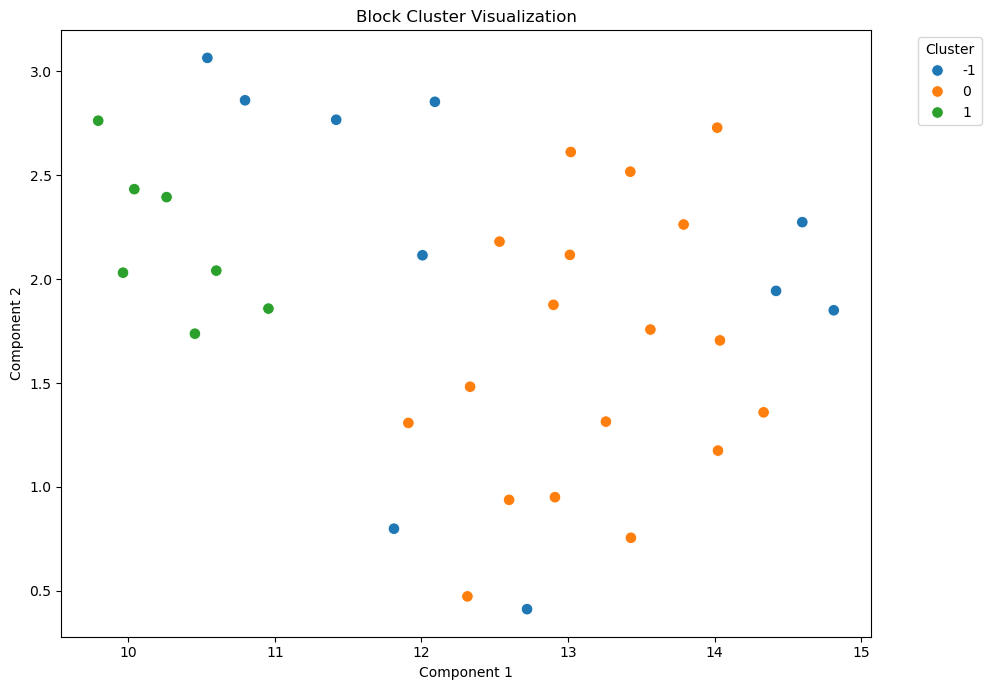

In [228]:
cleaned_html = clean_html(html_doc)
dom_tree = build_dom_tree(cleaned_html)
final_blocks = build_block_tree(dom_tree, max_window_tokens=256)

# block_texts = extract_block_texts(final_blocks)
# embed_block_contents(final_blocks, block_texts)
embed_block_nodes(final_blocks)
cluster_and_prune_blocks(final_blocks, max_link=5)
visualize_block_clusters(final_blocks)


document1_html1_body1_div1_div2_div5_ol1_ol1_split_0
document1_html1_body1_div1_div2_div5_ol1_ol1_split_1
document1_html1_body1_div1_div2_div5_ol1_ol1_split_2
document1_html1_body1_div1_div2_div5_ol1_ol1_split_3
document1_html1_body1_div1_div2_div5_ol1_ol1_split_4
document1_html1_body1_div1_div2_div5_ol1_ol1_split_5
document1_html1_body1_div1_div2_div5_ol1_ol1_split_6
document1_html1_body1_div1_div2_div5_tbody12_tbody12_split_0
document1_html1_body1_div1_div2_div5_tbody12_tbody12_split_1
document1_html1_body1_div1_div2_div5_div5_split_0
document1_html1_body1_div1_div2_div5_div5_split_1
document1_html1_body1_div1_div2_div5_div5_split_2
document1_html1_body1_div1_div2_div5_div5_split_3
document1_html1_body1_div1_div2_div5_div5_split_4
document1_html1_body1_div1_div2_div5_div5_split_5
document1_html1_body1_div1_div2_div5_div5_split_6
document1_html1_body1_div1_div2_div5_div5_split_7
document1_html1_body1_div1_div2_div5_div5_split_8
document1_html1_body1_div1_div2_div5_div5_split_9
documen

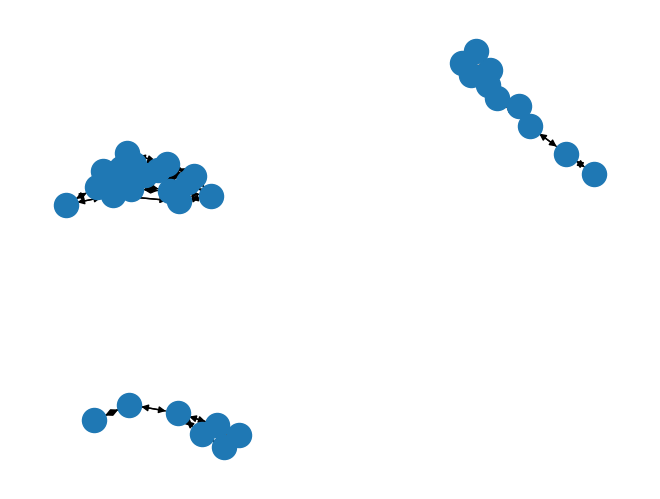

In [231]:
graph_construct(final_blocks)

In [206]:
final_blocks

[<BlockNode tag=div5_split_0 block='This article includes a , related reading or , .list of references external links but its sources remain unclear because it lacksinline citations Please help to this article by more precise citations.improve introducing (April 2011) ( )Learn how and when to remove this template message from humid winter-air deposits directly into a solid, crystalline frost pattern on a window, without ever being liquid in the process.Water vapor is a , a in which transforms into without passing through the . The reverse of deposition is and hence sometimes deposition is called .Deposition thermodynamic process phase transition gas solid liquid phase sublimation desublimation One example of deposition is the by which, in , changes directly to without first becoming a . This is how forms in , as well as how and form on the ground or other surfaces. Another example is when frost forms on a leaf. For deposition to occur, thermal energy must be removed from a gas. When th

In [17]:
print(block_tree)

Tag: document1, Content: html, Children: 2, Cluster: None


In [184]:
visualize_block_clusters(final_blocks)


1


ValueError: n_neighbors must be greater than 1

In [174]:
for blk in final_blocks:
    print(blk.cluster_label, blk.cluster_prob, blk.cluster_strength)

1 1.0 0.0
3 1.0 0.0
3 1.0 0.0
1 1.0 0.0
0 1.0 0.0
2 1.0 0.0
0 1.0 0.0
3 1.0 0.0
2 1.0 0.0
1 1.0 0.0
-1 0.0 0.09618456736168196
2 1.0 0.0
2 0.7797863239852073 0.22021367601479266
-1 0.0 0.18316125860767835
-1 0.0 0.060785334985511086
0 1.0 0.0
